C:\Users\jakob\AppData\Local\Temp\ipykernel_17856\85698251.py:25: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  Spotpris["Tid"] = pd.date_range(start="2023-01-01 00:00", periods=len(Spotpris), freq="H")
C:\Users\jakob\AppData\Local\Temp\ipykernel_17856\85698251.py:32: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  TOTel_df["Tid"] = pd.date_range(start="2023-01-01 00:00", periods=len(TOTel_df), freq="H")
C:\Users\jakob\AppData\Local\Temp\ipykernel_17856\85698251.py:36: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_max_effekt = TOTel_df["TOTel"].resample("M").max()  # Högsta värde per månad
C:\Users\jakob\AppData\Local\Temp\ipykernel_17856\85698251.py:50: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg_E = Spotpris["E"].resample("M").mean()
C:\Users\jakob\A

Summa kostnad i el 2023: 59635886.22332853
Justerad elkostnad simulering: 43518038.95015396


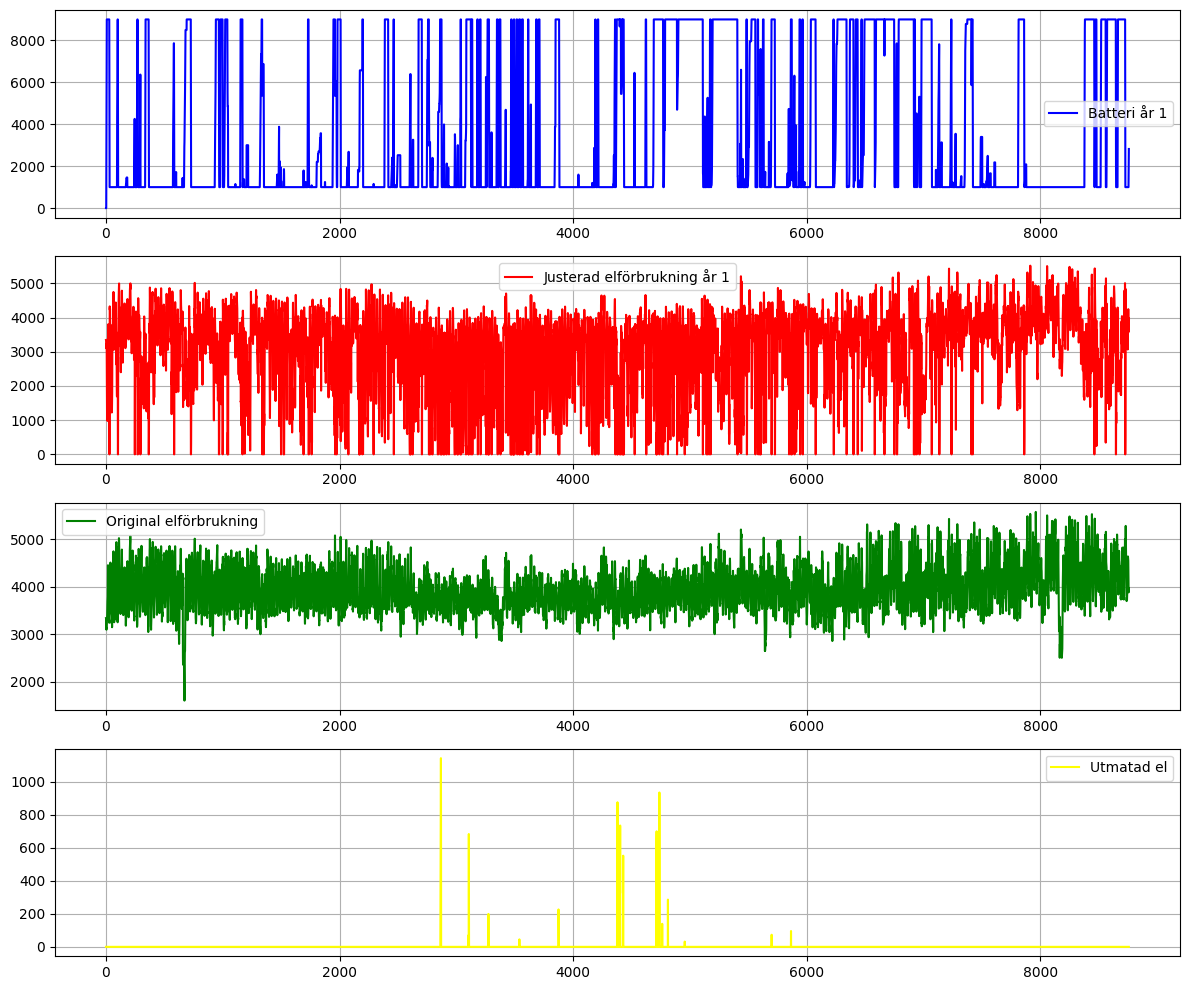

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Läs in Excel-filer
SolprodSödra = pd.read_excel("Soldata-filerSÖDRA/SummaSödraSolPROD.xlsx", header=None)
SödraOmrEL = pd.read_excel("Eldata-filerSÖDRA/SummaSödraOmrådet.xlsx", header=None)

SolprodABK = pd.read_excel("SolprodABK.xlsx", header=None)
ABKEl = pd.read_excel("ABKEL.xlsx", names=["ABKEl"], header=None)
Spotpris = pd.read_excel("Spotpris.xlsx", names=["Spotpris"], header=None)
Vindprod = pd.read_excel("Vindturbin.xlsx", header=None)
StarkaEl = pd.read_excel("Starka2023.xlsx", header=None)
KLTel = pd.read_excel("KLTelFörbr.xlsx", header=None)

NorraEL = StarkaEl.iloc[:, 0] + ABKEl.iloc[:, 0] + KLTel.iloc[:, 0]
SödraEL = SödraOmrEL.iloc[:, 0]
TOTel = NorraEL + SödraEL
Vind = Vindprod.iloc[:, 0]
Sol = 0.4*(SolprodABK.iloc[:, 0] + SolprodSödra.iloc[:, 0])
Spot = Spotpris.iloc[:, 0]

Prod = Vind + Sol

Spotpris["Tid"] = pd.date_range(start="2023-01-01 00:00", periods=len(Spotpris), freq="H")
Spotpris.set_index("Tid", inplace=True)

fastNätTOT = 342710

# Lägg till tidsindex för TOTel
TOTel_df = pd.DataFrame({"TOTel": TOTel})
TOTel_df["Tid"] = pd.date_range(start="2023-01-01 00:00", periods=len(TOTel_df), freq="H")
TOTel_df.set_index("Tid", inplace=True)

# Hitta maximal timmedeleffekt per månad
monthly_max_effekt = TOTel_df["TOTel"].resample("M").max()  # Högsta värde per månad

# Effektavgift (per kW)
effektavgift = 57.04  # kr/kW

# Beräkna effektkostnad per månad
effektkostnad_per_månad = monthly_max_effekt * effektavgift  # Kostnad per månad

# Summera effektkostnaden för hela året
total_effektkostnad = effektkostnad_per_månad.sum()

Spotpris["E"] = 2.23 + 0.0583 * Spotpris["Spotpris"]

# Beräkna genomsnittlig överföringsavgift per månad
monthly_avg_E = Spotpris["E"].resample("M").mean()

# Beräkna totala elförbrukningen per månad
monthly_total_TOTel = TOTel_df["TOTel"].resample("M").sum()

# Beräkna summa överföringsavgift för hela året
summaÖverföringsAvgift = (monthly_avg_E * monthly_total_TOTel).sum()

totElnätskostnad = fastNätTOT + total_effektkostnad + summaÖverföringsAvgift/100

elhandelskostnad = (Spot * TOTel).sum() / 100
energiskatt = (43.9 * TOTel).sum() / 100

summaElKostnad = (totElnätskostnad + elhandelskostnad + energiskatt) * 1.25
print("Summa kostnad i el 2023:", summaElKostnad)


# ----------------------- YEAR 1 SIMULATION -----------------------
batteriKapacitet = 0.0  # Start with an empty battery
batteriMaxKapacitet = 10000  # Max battery capacity in kWh
min_battery_level = batteriMaxKapacitet*0.1
max_battery_level = batteriMaxKapacitet * 0.9
maxFrånBatteri = max_battery_level*0.5
faktor = 0.1
original_consumption = TOTel.tolist()
justeradElförbrukning = []  # Adjusted electricity consumption for Year 1
battery_values = []  # Battery energy over time
utmatning = []
köptaTimmar = []

for tid, prod, totEl, spot in zip(Spotpris.index, Prod, TOTel, Spot):  
    diff = totEl - prod  # Skillnad mellan förbrukning och solproduktion

    if diff <= 0:
        # Om solproduktionen är större än förbrukningen, ladda batteriet istället för att spara negativa värden
        batteriKapacitet = min(batteriKapacitet - diff, max_battery_level)  # -diff eftersom diff är negativ
        justeradElförbrukning.append(0)  # Vi behöver inte köpa el
        utmatning.append(max(0,batteriKapacitet - diff - max_battery_level))
        köptaTimmar.append((tid,0))
    else:
        if spot <= 35 and prod > 0:
            if batteriKapacitet + prod >= max_battery_level: 
                prodÖver = (batteriKapacitet + prod) - max_battery_level
                batteriKapacitet = min(batteriKapacitet + prod, max_battery_level)
                köpt_el = max(0, totEl-prodÖver)
                justeradElförbrukning.append(köpt_el)  
                köptaTimmar.append((tid, spot if köpt_el > 0 else 0))
                utmatning.append(0)
            else:
                batteriKapacitet = min(batteriKapacitet + prod, max_battery_level)
                justeradElförbrukning.append(totEl)
                köptaTimmar.append((tid, spot))
                utmatning.append(0)  
        elif 35 < spot < 65.75 and prod > 0:
            justeradElförbrukning.append(diff)
            köptaTimmar.append((tid, spot))
            utmatning.append(0)
        elif spot >= 65.75:
            energiFrånBatteri = min(batteriKapacitet, diff, maxFrånBatteri, batteriKapacitet-min_battery_level)
            batteriKapacitet -= energiFrånBatteri
            köpt_el = max(0, diff - energiFrånBatteri)
            köptaTimmar.append((tid, spot if köpt_el > 0 else 0))
            justeradElförbrukning.append(köpt_el)
            utmatning.append(0)
        else:
            justeradElförbrukning.append(totEl)
            köptaTimmar.append((tid, spot))
            utmatning.append(0)


    battery_values.append(batteriKapacitet)



köptaTimmar_df = pd.DataFrame(köptaTimmar, columns=["Tid", "Spotpris"])
köptaTimmar_df.set_index("Tid", inplace=True)

köptaTimmar_df["E"] = 2.23 + 0.0583 * köptaTimmar_df["Spotpris"]

monthly_avg_E_köpt = köptaTimmar_df["E"].resample("M").mean()

elförbrukning_df = pd.DataFrame({"Tid": Spotpris.index, "elförbrukning": justeradElförbrukning})
elförbrukning_df.set_index("Tid", inplace=True)

monthly_total_elförbrukning = elförbrukning_df["elförbrukning"].resample("M").sum()

summaJusteradÖverf = (monthly_avg_E_köpt * monthly_total_elförbrukning).sum()

summaJusteradÖverfKR = (summaJusteradÖverf / 100) + fastNätTOT

# Filtrera elförbrukning endast för de köpta timmarna
elförbrukning_köpt = elförbrukning_df.loc[köptaTimmar_df.index]

# Beräkna elhandelskostnaden: Spotpris * elförbrukning
elhandelskostnad_köpt = (köptaTimmar_df["Spotpris"] * elförbrukning_köpt["elförbrukning"]).sum() / 100

# Beräkna den justerade energiskatten
total_elförbrukning = sum(justeradElförbrukning)
JusteradEnergiskatt = (total_elförbrukning * 43.9) / 100


# Beräkna den justerade elkostnaden
summaJusteradElkostnad = 1.25 * (summaJusteradÖverfKR + JusteradEnergiskatt + elhandelskostnad_köpt)
print("Justerad elkostnad simulering:", summaJusteradElkostnad)


# ----------------------- PLOTTING RESULTS -----------------------
fig, ax = plt.subplots(4, 1, figsize=(12, 10))

ax[0].plot(battery_values, label='Batteri år 1', color='blue')
ax[1].plot(justeradElförbrukning, label='Justerad elförbrukning år 1', color='red')
ax[2].plot(original_consumption, label='Original elförbrukning', color='green')
ax[3].plot(utmatning, label='Utmatad el', color='yellow')

for a in ax:
    a.legend()
    a.grid(True)

plt.tight_layout()
plt.show()
